## Results on UCIdataset
source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import craftai.pandas
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import seaborn as sns
from fbprophet import Prophet
import imp
import grid_tools as grid
import benchmark_tools as bt

In [2]:
imp.reload(grid)

<module 'grid_tools' from 'C:\\Users\\Claire\\Documents\\craft-ai-kit-energy\\benchmark\\grid_tools.py'>

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#configurating seaborn
palette = sns.color_palette("Set2", 10, 0.9)
sns.set_palette(palette)
sns.set_style("dark")

In [139]:
data = pd.read_csv('data/uci/uci_household_power_consumption.csv', parse_dates=['date'])

In [140]:
virgin_data = data.copy(deep=True)

In [169]:
data = virgin_data

In [170]:
data.head()

,date,load
0,2006-12-16 17:24:00,4216.0
1,2006-12-16 17:25:00,5360.0
2,2006-12-16 17:26:00,5374.0
3,2006-12-16 17:27:00,5388.0
4,2006-12-16 17:28:00,3666.0


In [171]:
data.tail()

,date,load
2075254,2010-11-26 20:58:00,946.0
2075255,2010-11-26 20:59:00,944.0
2075256,2010-11-26 21:00:00,938.0
2075257,2010-11-26 21:01:00,934.0
2075258,2010-11-26 21:02:00,932.0


In [172]:
print('Dataset: {} rows, {} columns'.format(data.shape[0],data.shape[1]))
print(' {:f} % of rows with unknown values'.format((1 -data.dropna().shape[0]/ data.shape[0]) *100))

Dataset: 2075259 rows, 2 columns
 1.251844 % of rows with unknown values


For the kit : where do the last 3 years start ? 

In [173]:
week_unit = 7*24*60

print('How many weeks in the data  ? ')
print(data.shape[0] / week_unit)

week_offset = 50
start_index = week_offset * week_unit
print('Training will start at week {}, so index  {} :'.format(week_offset, start_index))

start_pred_index = start_index + 2*52*week_unit
print('Predictions will start at week {}, so index  {}:'.format(week_offset+2*52, start_pred_index))


How many weeks in the data  ? 
205.87886904761905
Training will start at week 50, so index  504000 :
Predictions will start at week 154, so index  1552320:


In [162]:
data[data['date']==pd.to_datetime('2010-06-26 17:23:00')]

,date,load
1854719,2010-06-26 17:23:00,1310.0


In [174]:
#Remove the first year to let only the last 3 years for predictions
data = data.iloc[start_index-1:]

# Getting rid of nan values
data.index = pd.to_datetime(data.date)
data = data.drop('date',1) # no dropna to have same conditions with craft
print('Cleaned dataset: {:d} rows, {:d} columns'.format(data.shape[0],data.shape[1]))
print('Types of data: \n{}'.format(data.dtypes))

Cleaned dataset: 1571260 rows, 1 columns
Types of data: 
load    float64
dtype: object


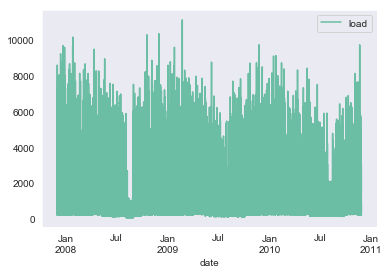

In [149]:
data.plot()

In [150]:
#Adding temperature information
temp = pd.read_json('provider/weather_cache_uci.json', convert_dates=['date'])
temp['date'] = temp.iloc[:,0].str.extract(r'[\d]+\.[\d]+,[\d]+\.[\d]+,([\d]+)')
temp['temperatureLow'] = temp.iloc[:,1].apply(lambda x : x['temperatureLow'])
temp['temperatureHigh'] = temp.iloc[:,1].apply(lambda x : x['temperatureHigh'])
temp.index = pd.to_datetime(temp.date, unit='s')
temp = temp.sort_index()
temp = temp.drop([0,1,'date'],1)

In [151]:
temp.shape, temp.index[0], temp.index[-1]

((2150, 2), Timestamp('2006-12-15 23:00:00'), Timestamp('2010-11-26 19:13:00'))

In [152]:
temp.iloc[240:].head()

,temperatureLow,temperatureHigh
date,,
2007-11-30 23:00:00,7.84,10.56
2007-12-01 17:23:00,7.84,10.56
2007-12-01 23:00:00,7.54,11.39
2007-12-02 23:00:00,6.64,10.87
2007-12-03 23:00:00,10.30,10.56


In [153]:
data.head()

,load
date,
2007-12-01 17:23:00,2772.0
2007-12-01 17:24:00,2724.0
2007-12-01 17:25:00,2736.0
2007-12-01 17:26:00,2746.0
2007-12-01 17:27:00,2740.0


In [154]:
data.tail()

,load
date,
2010-11-26 20:58:00,946.0
2010-11-26 20:59:00,944.0
2010-11-26 21:00:00,938.0
2010-11-26 21:01:00,934.0
2010-11-26 21:02:00,932.0


In [175]:
data = data.merge(temp, how='left', left_index=True, right_index=True)

In [176]:
data.count()

load               1549215
temperatureLow        1909
temperatureHigh       1909
dtype: int64

In [177]:
data = data.fillna(method='ffill')
data = data[1:] #to find the same conditions with craft

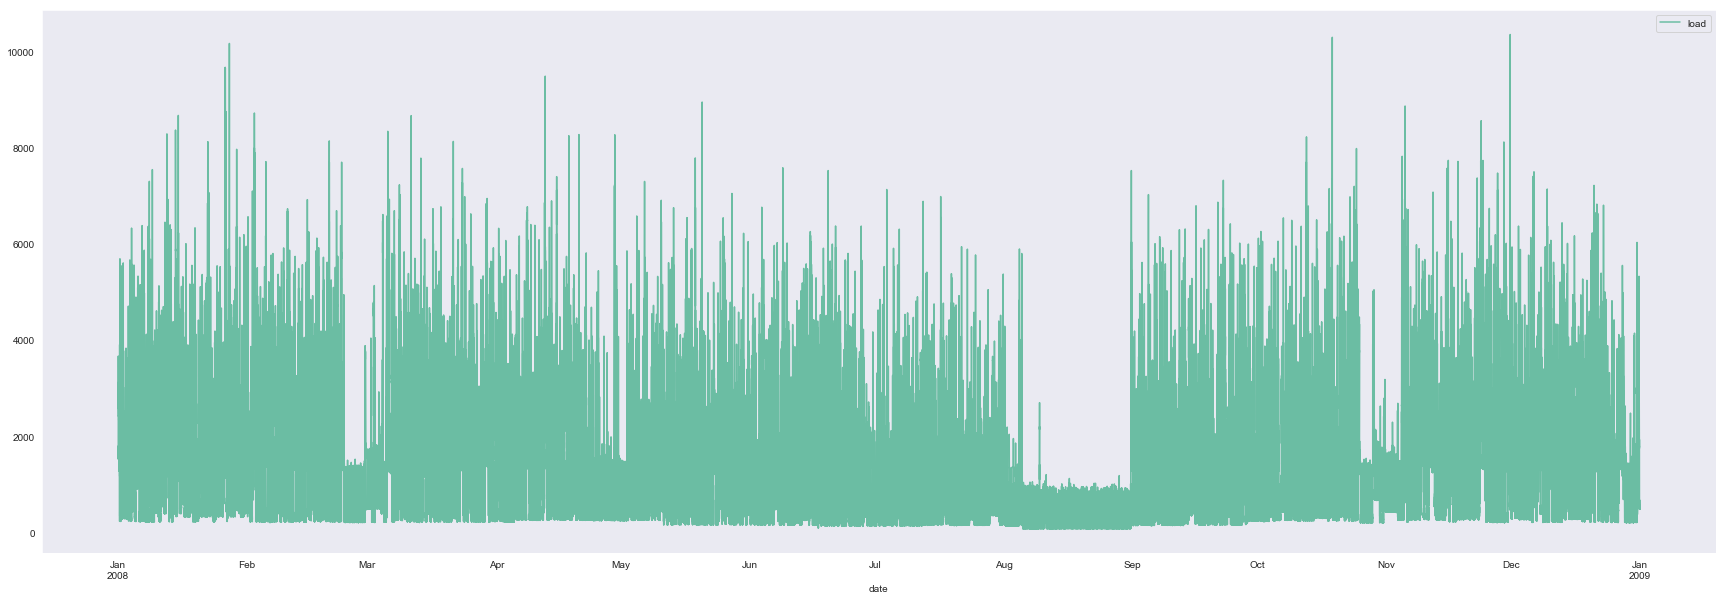

In [77]:
#Plotting the data for year 2008
data_2 = data[data.index<pd.to_datetime('2009-01-01')]
data_2 = data_2.loc[data_2.index>=pd.to_datetime('2008-01-01')]
data_2.plot(y='load', figsize=(30,10))
plt.show()

In [188]:
#The big abandon : resampling uci to 30min
uci = data.resample('30T').first()

In [189]:
uci.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:00:00,2724.0,7.84,10.56
2007-12-01 17:30:00,2706.0,7.84,10.56
2007-12-01 18:00:00,3880.0,7.84,10.56
2007-12-01 18:30:00,2798.0,7.84,10.56
2007-12-01 19:00:00,3436.0,7.84,10.56


In [180]:
week_unit = 7*24*2

print('How many weeks in the data  ? ')
print(uci.shape[0] / week_unit)

week_offset = 50
start_index = week_offset * week_unit
print('Training will start at week {}, so index  {} :'.format(week_offset, start_index))

start_pred_index = start_index + 2*52*week_unit
print('Predictions will start at week {}, so index  {}:'.format(week_offset+2*52, start_pred_index))


How many weeks in the data  ? 
155.88392857142858
Training will start at week 50, so index  16800 :
Predictions will start at week 154, so index  51744:


**Methodology for choosing depth**

* We remove the first year
* We feed the models the first 2 years of data except the last two weeks
* We predict on the next week

In [181]:
week_unit = 7*24*2
data_train= uci.iloc[:start_pred_index - (week_offset+ 2) * week_unit,:]
data_test = uci.iloc[start_pred_index - (week_offset+ 2) * week_unit:start_pred_index - (week_offset +1) * week_unit,:]#predict on first 2 weeks

In [182]:
print('Train dataset: {} rows, {} columns'.format(data_train.shape[0],data_train.shape[1]))
print('Test dataset: {} rows, {} columns'.format(data_test.shape[0],data_test.shape[1]))

Train dataset: 34272 rows, 3 columns
Test dataset: 336 rows, 3 columns


In [183]:
data_test.head()

,load,temperatureLow,temperatureHigh
date,,,
2009-11-14 17:00:00,1764.0,10.11,14.27
2009-11-14 17:30:00,2720.0,10.11,14.27
2009-11-14 18:00:00,4886.0,10.11,14.27
2009-11-14 18:30:00,2988.0,10.11,14.27
2009-11-14 19:00:00,2830.0,10.11,14.27


In [184]:
data_test.tail()

,load,temperatureLow,temperatureHigh
date,,,
2009-11-21 14:30:00,298.0,10.31,15.73
2009-11-21 15:00:00,590.0,10.31,15.73
2009-11-21 15:30:00,660.0,10.31,15.73
2009-11-21 16:00:00,3536.0,10.31,15.73
2009-11-21 16:30:00,3822.0,10.31,15.73


In [190]:
uci.index = uci.index.tz_localize('utc').tz_convert('Europe/Paris').map(lambda x : x.isoformat())

In [191]:
uci.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01T18:00:00+01:00,2724.0,7.84,10.56
2007-12-01T18:30:00+01:00,2706.0,7.84,10.56
2007-12-01T19:00:00+01:00,3880.0,7.84,10.56
2007-12-01T19:30:00+01:00,2798.0,7.84,10.56
2007-12-01T20:00:00+01:00,3436.0,7.84,10.56


In [195]:
uci.tail()

,load,temperatureLow,temperatureHigh
date,,,
2010-11-26T20:00:00+01:00,1810.0,-0.93,3.14
2010-11-26T20:30:00+01:00,1908.0,-0.93,3.14
2010-11-26T21:00:00+01:00,1456.0,-0.93,3.14
2010-11-26T21:30:00+01:00,980.0,-0.93,3.14
2010-11-26T22:00:00+01:00,938.0,-0.93,3.14


In [194]:
uci.drop(['temperatureLow','temperatureHigh'],1).to_csv('data/uci/uci_30T.csv')

### Searching for the best parameters 

In [49]:
print(' \n Searching the best parameters for scikit tree Regressor :')
data_train= data.iloc[:start_pred_index - (week_offset+ 1) * week_unit,:]
data_test = data.iloc[start_pred_index - (week_offset+ 1) * week_unit:start_pred_index - week_offset * week_unit,:]#predict on first 2 weeks
grid.scikit_param_search(data_train, data_test, exog = ['temperatureLow', 'temperatureHigh'])

print(' \n Searching the best parameters for scikit random forest regressor :')
print('\nFor rmse :')
grid.random_forest_grid(data_train, data_test, metric='rmse', exog = ['temperatureLow', 'temperatureHigh'])
print('\nFor mape :')
grid.random_forest_grid(data_train, data_test, metric='mape', exog = ['temperatureLow', 'temperatureHigh'])
print('\nFor r2 :')
grid.random_forest_grid(data_train, data_test, metric='r2', exog = ['temperatureLow', 'temperatureHigh'])

 
 Searching the best parameters for scikit tree Regressor :
Best scores : 
      best score  depth
mae   590.760000      9
rmse  966.970000     10
r2      0.414231     10
 
 Searching the best parameters for scikit random forest regressor :

For rmse :
          best score  n_estimators
depth: 1     1179.69             7
depth: 2     1129.97             3
depth: 3     1082.67             3
depth: 4     1044.71             4
depth: 5     1012.02             4
depth: 6      991.32             2
depth: 7      988.89             8
depth: 8      976.15             2
depth: 9      959.91             9

 Best parameters for Random Forest Regressor : 
 depth: 9 
 n_estimators :9.0

For mape :
          best score  n_estimators
depth: 1       72.53             3
depth: 2       81.32             7
depth: 3       76.09             2
depth: 4       69.29             2
depth: 5       67.38             2
depth: 6       62.83             2
depth: 7       59.70             2
depth: 8       62.39     

,depth: 1,depth: 2,depth: 3,depth: 4,depth: 5,depth: 6,depth: 7,depth: 8,depth: 9
n_estimators,,,,,,,,,
2,0.127,0.200,0.265,0.310,0.335,0.384,0.373,0.403,0.375
3,0.127,0.200,0.266,0.314,0.346,0.376,0.372,0.396,0.378
4,0.126,0.200,0.265,0.316,0.358,0.376,0.382,0.392,0.399
5,0.128,0.199,0.264,0.312,0.343,0.370,0.384,0.398,0.403
6,0.128,0.199,0.262,0.314,0.348,0.376,0.384,0.392,0.396
7,0.128,0.199,0.263,0.313,0.347,0.375,0.384,0.390,0.397
8,0.128,0.199,0.263,0.311,0.346,0.372,0.387,0.401,0.418
9,0.128,0.199,0.263,0.312,0.346,0.375,0.384,0.401,0.423


#### Search for craft 

In [28]:
preds5 = pd.read_json('preds/uci_test_5_rolling_results.json', convert_dates=['date']).set_index('date')
preds6 = pd.read_json('preds/uci_test_6_rolling_results.json', convert_dates=['date']).set_index('date')
preds7 = pd.read_json('preds/uci_test_7_rolling_results.json', convert_dates=['date']).set_index('date')
preds8 = pd.read_json('preds/uci_test_8_rolling_results.json', convert_dates=['date']).set_index('date')
preds9 = pd.read_json('preds/uci_test_9_rolling_results.json', convert_dates=['date']).set_index('date')
preds10 = pd.read_json('preds/uci_test_10_rolling_results.json', convert_dates=['date']).set_index('date')
preds11 = pd.read_json('preds/uci_test_11_rolling_results.json', convert_dates=['date']).set_index('date')
preds12 = pd.read_json('preds/uci_test_12_rolling_results.json', convert_dates=['date']).set_index('date')
preds7 = preds7.iloc[:10080]

In [29]:
craft_preds = [preds5, preds6, preds7, preds8, preds9, preds10, preds11, preds12]

In [30]:
print(bt.get_models_scores(data_test, idx= [5, 6, 7,8,9,10,11,12], 
                               predictions=[i.predictedLoad.values for i in craft_preds]))

        mae   mape     rmse        r2
ids                                  
5    645.50  72.21   987.47  0.282370
6    670.88  74.59  1038.51  0.206267
7    635.51  69.46   986.21  0.284200
8    678.10  70.07  1049.09  0.190019
9    721.94  81.14  1115.62  0.084031
10   771.92  83.10  1192.37 -0.046340
11   831.58  88.72  1271.18 -0.189218
12   782.37  87.64  1194.80 -0.050607


In [222]:
print(' Without temperature data : \n Searching the best parameters for scikit tree Regressor :')
grid.scikit_param_search(data_train, data_test)

 Without temperature data : 
 Searching the best parameters for scikit tree Regressor :
Best scores : 
      best score  depth
mae   566.220000      8
rmse  796.580000      6
r2      0.305039      6


,depth,mae,rmse,r2
0,1,577.68,857.78,0.194152
1,2,635.85,879.59,0.152649
2,3,620.13,861.53,0.187100
3,4,603.89,847.37,0.213602
4,5,590.35,825.23,0.254146
5,6,568.29,796.58,0.305039
6,7,580.28,816.51,0.269835
7,8,566.22,822.79,0.258565
8,9,576.36,811.89,0.278070
9,10,594.92,826.75,0.251403


### Sarima model !

Best parameters on [0,1]^6 computed in arima_grid notebook : SARIMA(1, 0, 1)x(0, 1, 1, 48) for AIC = 76466.42140598648

In [141]:
arima_train = data_train.drop('temp',1)

In [142]:
arima_train.head()

,load
date,
2012-04-01 07:00:00,1947.400000
2012-04-01 07:30:00,1269.766667
2012-04-01 08:00:00,1645.300000
2012-04-01 08:30:00,845.666667
2012-04-01 09:00:00,1584.966667


To avoid memory errors, let's train our ARIMA model on the last 5000 entries only.

In [225]:
model = SARIMAX(data_train.loc[:,'load'].values[-5000:],
                            order= (1,0,1), 
                            seasonal_order = (0,1,1,48),
                            exog = data_train.iloc[-5000:,1],
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
arima_results = model.fit()

C:\Users\Claire\Anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
C:\Users\Claire\Anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


In [226]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 48)   Log Likelihood              -37792.354
Date:                            Mon, 24 Sep 2018   AIC                          75594.708
Time:                                    15:05:36   BIC                          75627.195
Sample:                                07-25-2013   HQIC                         75606.106
                                     - 11-06-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -7.2216      5.103     -1.415      0.157     -17.223       2.780
ar.L1          0.4075      0.020     19.884      0.000       0.367       0.448
ma.L1          0.0747      0.023      3.186      0.001       0.029       0.121
ma.S.L48      -0.9474      0.003   -285.611      0.000      -0.954      -0.941
sigma2      2.868e+05   2101.089    136.498      0.000    2.83e+05    2.91e+05
===================================================================================
Ljung-Box (Q):                      111.72   Jarque-Bera (JB):             62929.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             2.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

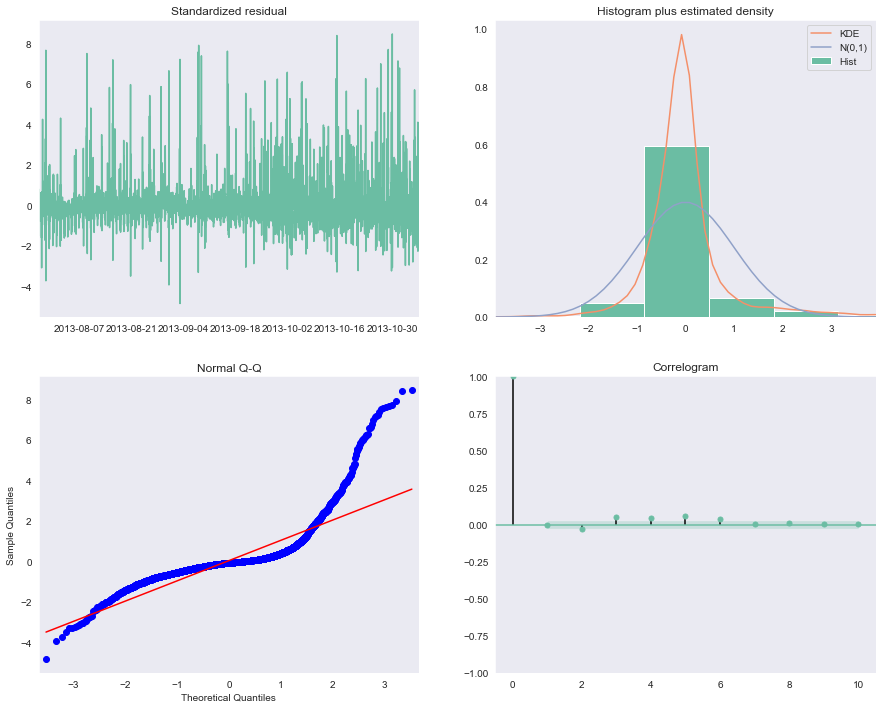

In [227]:
arima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [229]:
limit = 7*24*2
start = 5001
stop = 5001 + limit-2
arima_pred = arima_results.get_prediction(start, stop, dynamic=False, exog = data_test[['temp']].iloc[:limit,:])

In [230]:
arima_preds = arima_pred.predicted_mean
arima_confs = arima_pred.conf_int()

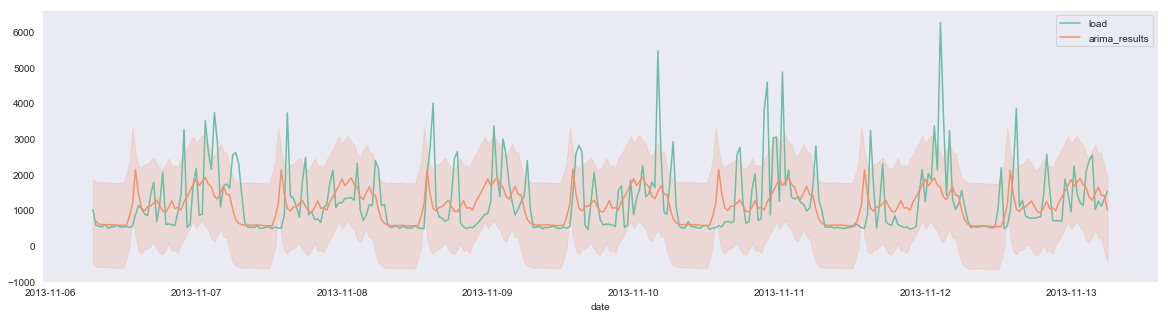

In [232]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1).iloc[:limit-1,:]
bench['arima_results'] = arima_preds
sns.lineplot(data=bench, dashes=False)
plt.fill_between(x=bench.index, y1=arima_confs['lower y'], y2 = arima_confs['upper y'], alpha=0.2, color=palette[1])
plt.show()

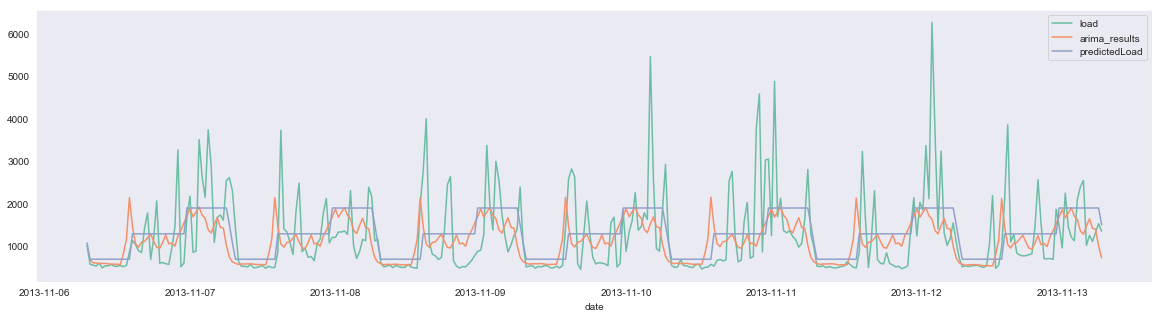

In [233]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1).iloc[:limit,:]
bench['arima_results'] = arima_preds
bench = bench.merge(craft_preds[['predictedLoad']].iloc[:limit,:], left_index=True, right_index=True)
sns.lineplot(data=bench, dashes=False)
plt.show()

### First Benchmark 

In [234]:
ground_values = data_test['load'].values
kit_results , pm_preds= craft_preds['predictedLoad'].values, df_compare.yhat.values
predictions = [kit_results, sk_results, forest_results, pm_preds, arima_preds]
ids= ['craft kit', 'scikit tree', 'scikit forest','prophet', 'sarimax']
maes=[]
mapes=[]
rmse=[]
for pred in predictions:
    gv = ground_values if len(pred) == len(ground_values) else ground_values[:len(pred)]
    maes.append(compute_mae(gv,pred))
    rmse.append(compute_rmse(gv,pred))
    mapes.append(compute_mape(gv,pred))
benchmark = pd.DataFrame(data={
    'ids': ids,
    'mae': maes,
    'mape': mapes,
    'rmse': rmse
})

In [235]:
benchmark

,ids,mae,mape,rmse
0,craft kit,541.0,51.61,770.0
1,scikit tree,523.0,48.82,769.0
2,scikit forest,530.0,50.08,763.0
3,prophet,541.0,53.12,773.0
4,sarimax,592.0,51.84,892.0


### Testing functions from ampds_benchmark_tools

In [32]:
import ampds_benchmark_tools as abt
imp.reload(abt)

<module 'ampds_benchmark_tools' from 'C:\\Users\\Claire\\Documents\\craft-ai-kit-energy\\benchmark\\ampds_benchmark_tools.py'>

In [18]:
data.head()

,load,temp
date,,
2012-04-01 07:00:00,1947.400000,4.7
2012-04-01 07:30:00,1269.766667,4.7
2012-04-01 08:00:00,1645.300000,5.3
2012-04-01 08:30:00,845.666667,5.3
2012-04-01 09:00:00,1584.966667,5.9


In [19]:
week_unit = 7*24*2 #nombre de demi-heures dans une semaine
last_train_index = 50*week_unit
last_test_index = last_train_index + week_unit
tr, tst = abt.split_data(data, last_train_index , last_test_index)

In [20]:
skr = abt.get_scikit_preds(tr, tst)
fore = abt.get_forest_preds(tr, tst)

In [40]:
pmr = abt.get_prophet_preds(tr, tst)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [26]:
cpre = abt.get_craft_preds(stop_train=last_train_index, start_pred=last_train_index, stop_pred=last_test_index, node_file = "load_benchmark_ampds_depth3")

In [28]:
crp = cpre['predictedLoad']
std = cpre['standardDeviation']

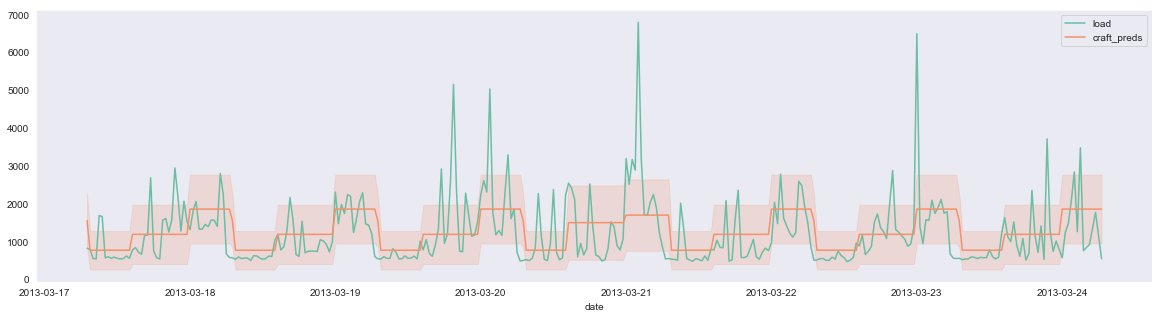

In [34]:
predictions = {'craft_preds': crp.values}
abt.plot_period_predictions(data_test=tst.drop('temp',1),
                        predictions=predictions,
                        standardDev = True,
                        low_val =crp- std,
                        upper_val =crp+ std)

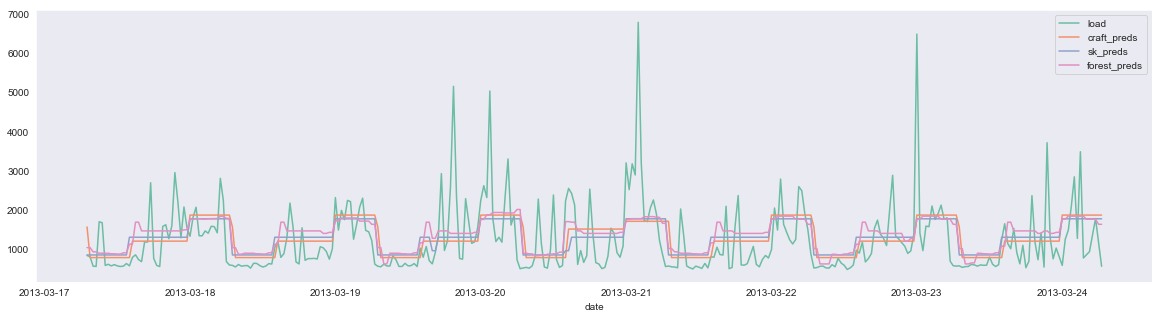

In [37]:
predictions = {'craft_preds':crp.values, 
                'sk_preds':skr, 
                'forest_preds':fore, 
              }

abt.plot_period_predictions(data_test=tst.drop('temp',1),
                            predictions=predictions)

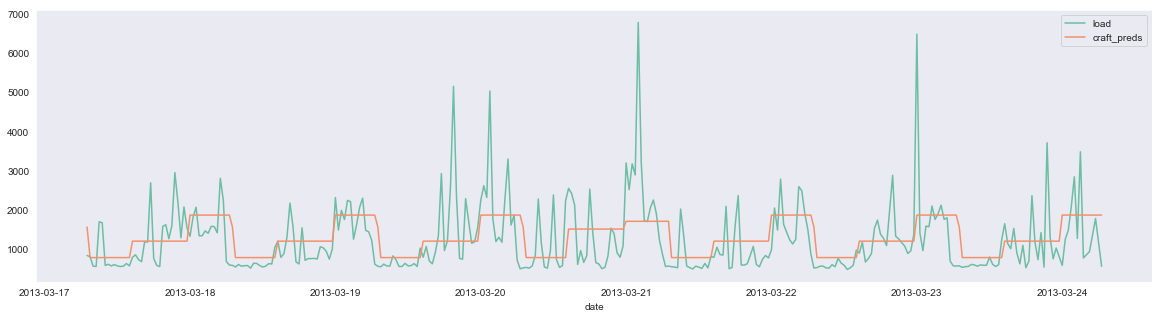

In [38]:
predictions = {'craft_preds': crp.values}
abt.plot_period_predictions(data_test=tst.drop('temp',1),
                        predictions=predictions, 
                        standardDev = True)

In [41]:
abt.get_models_scores(data_test=tst,
                      predictions=[skr, fore, pmr, crp], 
                      idx = ['a', 'b', 'c', 'd'])

,ids,mae,mape,rmse,r2
0,a,515.0,51.01,757.0,0.229920
1,b,541.0,56.12,765.0,0.214302
2,c,591.0,64.59,782.0,0.177893
3,d,518.0,50.68,774.0,0.195655
